In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf,read_raw_fif
from mne.datasets import eegbci
from mne.decoding import CSP

Opening raw data file dataset\2amoabb\train\0-raw.fif...
    Range : 0 ... 96734 =      0.000 ...   386.936 secs
Ready.
Reading 0 ... 96734  =      0.000 ...   386.936 secs...
<Info | 10 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG, 3 EOG, 1 Stimulus
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 26
 projs: []
 sfreq: 250.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.50 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-dom

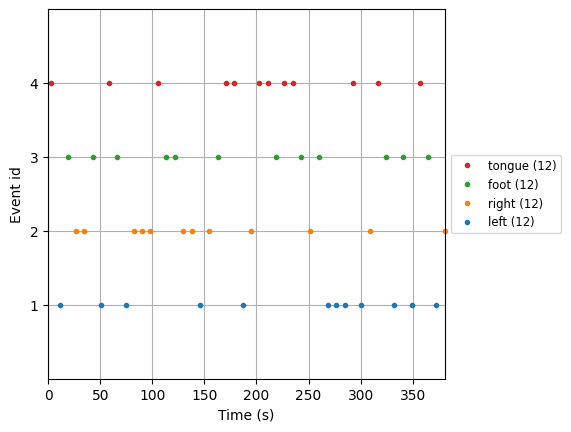

Not setting metadata
Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated
Loading data for 48 events and 1126 original time points ...
0 bad epochs dropped


In [18]:
def get_data():
    path = "dataset\\2amoabb\\train"
    test_path = "dataset\\2amoabb\\train\\0-raw.fif"
    files = os.listdir(path)
    data_path = []
    for f in files:
        file = os.path.join(path,f)
        data_path.append(file)
        
    
    tmin, tmax = -0.5, 4.
    event_id = dict(left=1, right = 2, foot=3,tongue=4)

    #raw = concatenate_raws([read_raw_fif(f, preload=True) for f in data_path])
    raw = concatenate_raws([read_raw_fif(test_path, preload=True)])
    raw_data = raw.copy()
    print(raw_data.info)
    # strip channel names of "." characters
    raw_data.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    #skip_by_annotation='edge'
    raw_data.filter(l_freq=0.5, h_freq=None, method = 'iir', skip_by_annotation='edge')
    raw_data.notch_filter(50)

    events, _ = events_from_annotations(raw_data)
    print(events)
    #ploting
    fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'],
                          first_samp=raw_data.first_samp, event_id=event_id)
    
    
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    
    # Read epochs (train will be done only between 1 and 2s)
    #reject_criteria = dict( eeg=100e-6)       # 100 µV
    # Testing will be done with a running classifier
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    #epochs.crop(tmin=1., tmax=None)
    labels = epochs.events[:, 2] -1
    return epochs.get_data()[:, :, :256], labels,epochs,raw_data


epochs_data, labels,epochs1,raw= get_data()

In [19]:
# 280 events
# 22 channel
# 256 Time

print(epochs_data.shape)
print(labels.shape)
print(epochs_data.shape[1])
print(labels)
print(raw.info)


(48, 22, 256)
(48,)
22
[3 0 2 1 1 2 0 3 2 0 1 1 1 3 2 2 1 1 0 1 2 3 3 0 1 3 3 2 3 3 2 1 2 0 0 0 3
 0 1 3 2 0 2 0 3 2 0 1]
<Info | 10 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG, 3 EOG, 1 Stimulus
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 26
 projs: []
 sfreq: 250.0 Hz
>


<Epochs |  48 events (all good), -0.5 - 4 sec, baseline off, ~9.1 MB, data loaded,
 'foot': 12
 'left': 12
 'right': 12
 'tongue': 12>


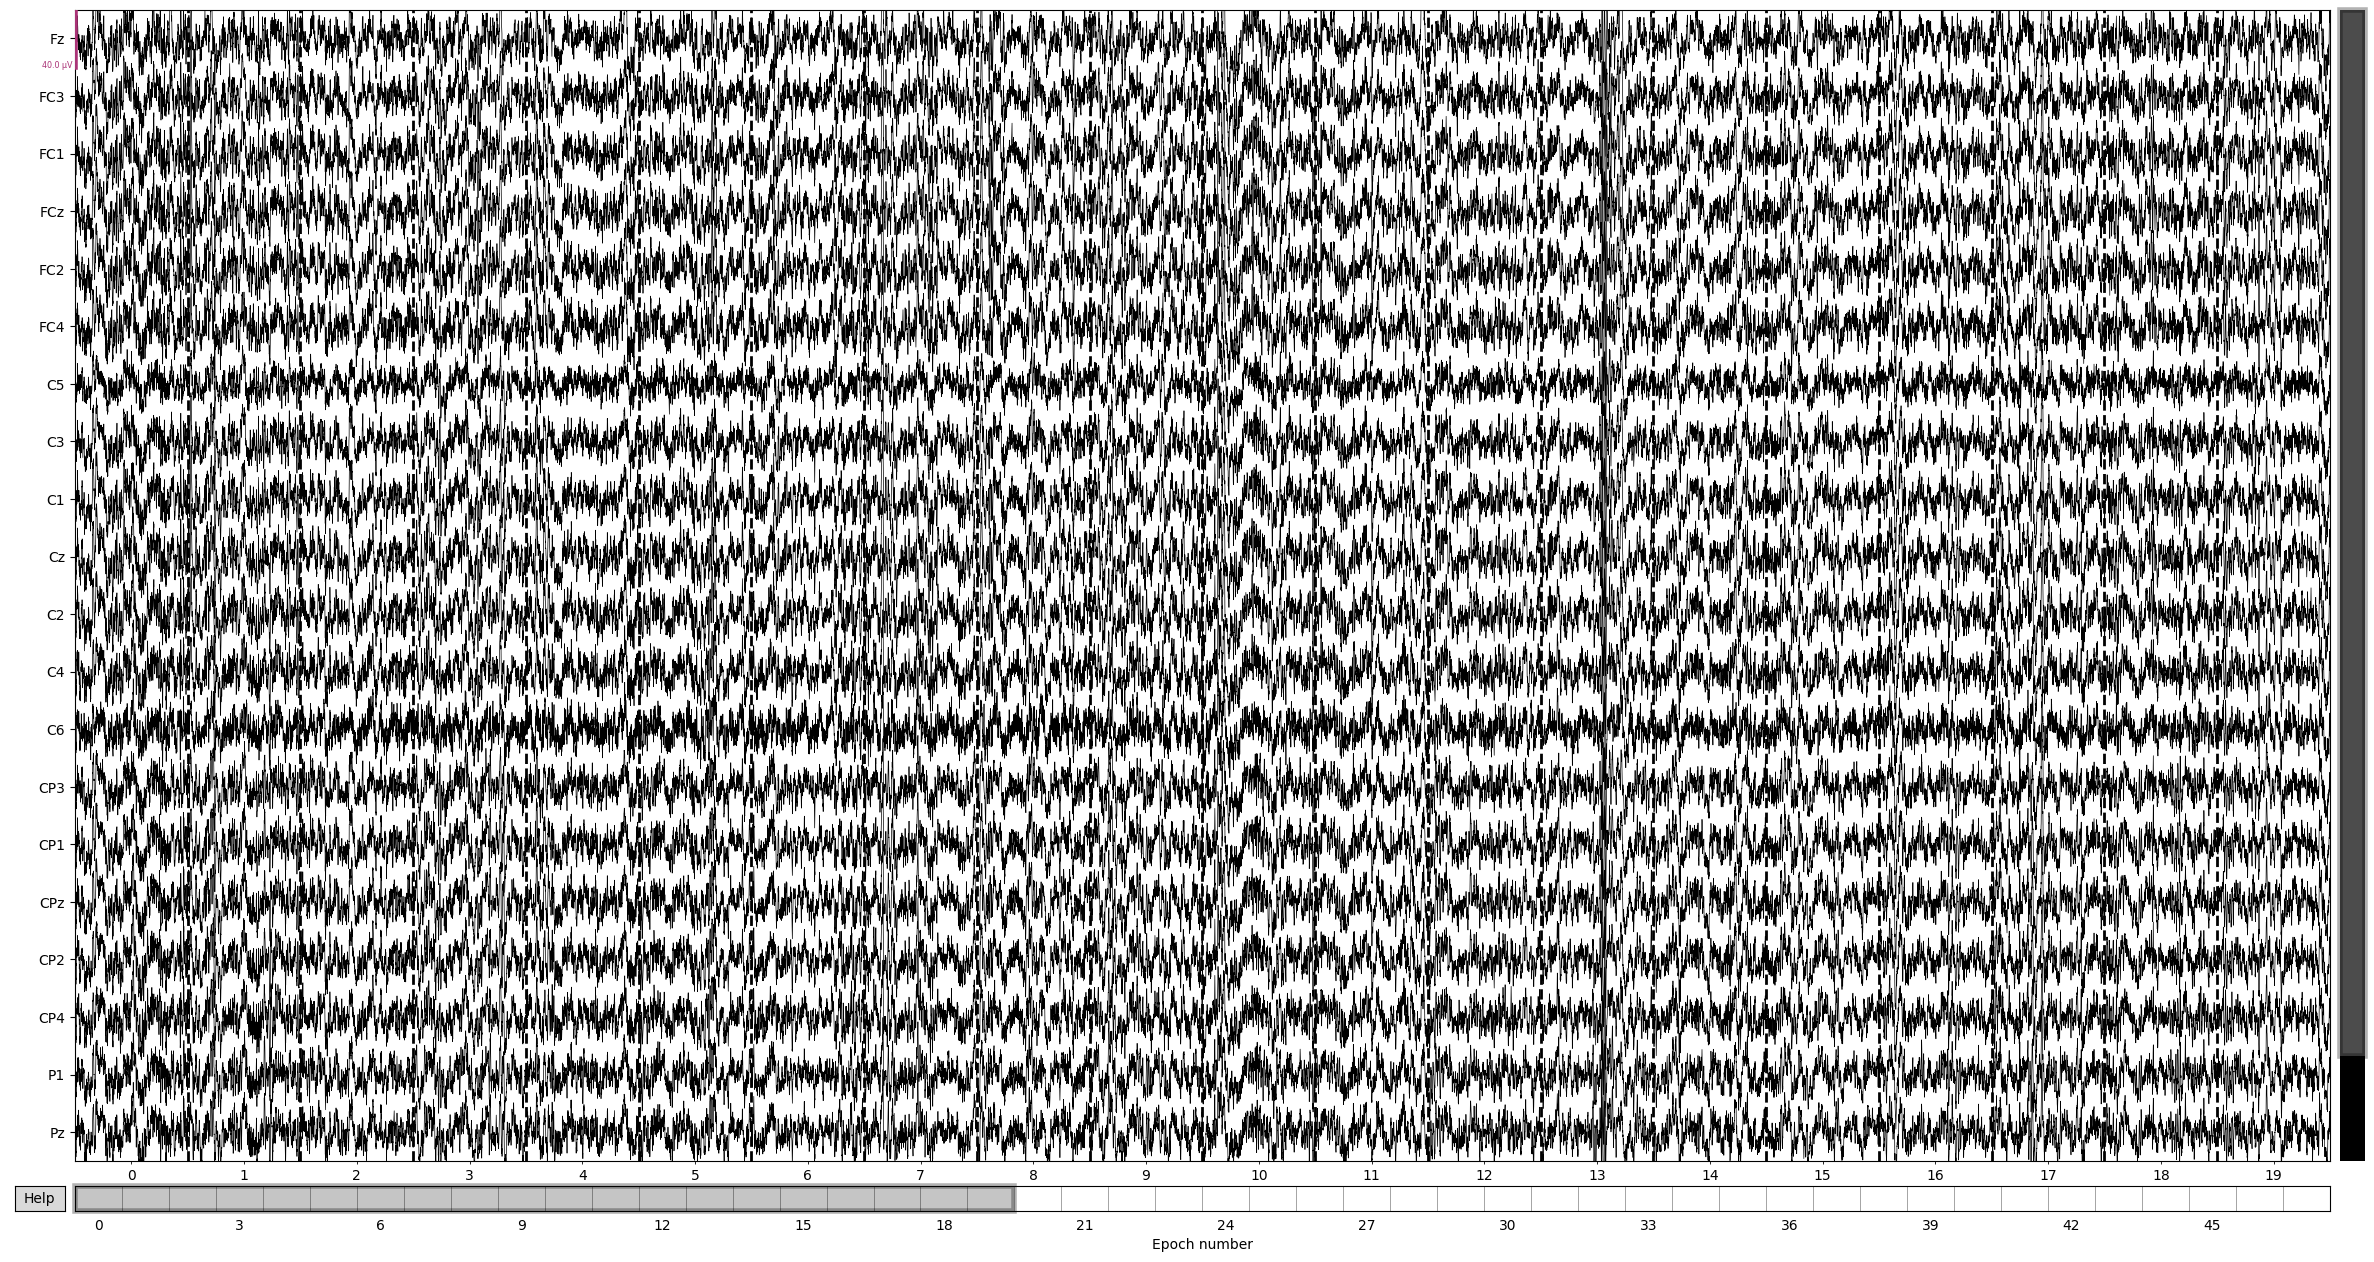

    Using multitaper spectrum estimation with 7 DPSS windows


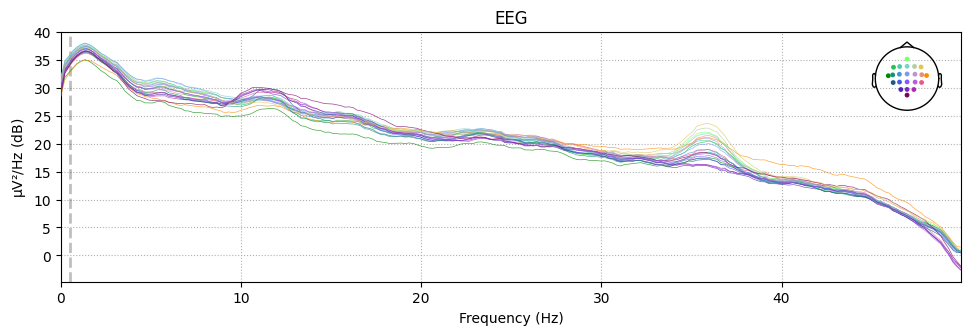

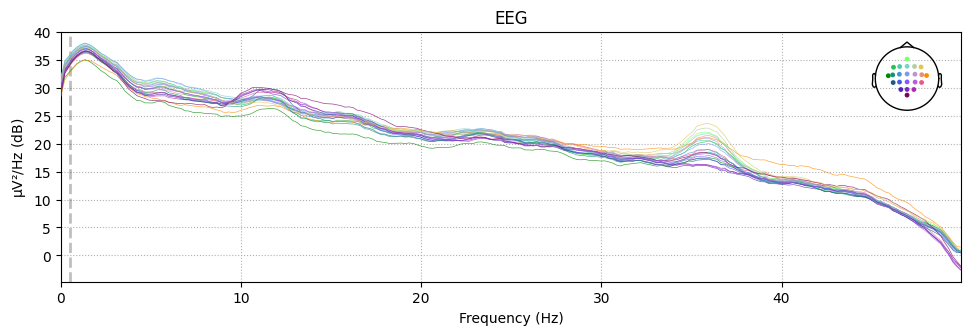

In [20]:
print(epochs1)
epochs1.plot()
epochs1.plot_psd(fmax=50)

In [8]:
def amplitude(x):
    """Data augmentation for adding noise to amplitude of sepctral image
    1 electrode คือ การดึงค่าคลื่นจาก electrode นั้นมา ซึ้่ง electrode นั้นคือ fc fz c4 c3 ประมาณนี้
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        reconstructed new time series from inverse STFT
    """
    print("Hello")



In [10]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import RandomSampler  
from torch.utils.data import SequentialSampler  

from common import EpochsDataset  

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)
train_idx, test_idx = next(cv_split)


def scale(X):
    """Standard scaling of data along the last dimention.
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    return X / 2e-5

dataset = EpochsDataset(epochs_data, labels, transform=scale)

ds_train, ds_valid = Subset(dataset, train_idx), Subset(dataset, test_idx)

batch_size_train = len(ds_train)
batch_size_valid = len(ds_valid)
sampler_train = RandomSampler(ds_train)
sampler_valid = SequentialSampler(ds_valid)

# create loaders
num_workers = 0
loader_train = \
    DataLoader(ds_train, batch_size=batch_size_train,
               num_workers=num_workers, sampler=sampler_train)
loader_valid = \
    DataLoader(ds_valid, batch_size=batch_size_valid,
               num_workers=num_workers, sampler=sampler_valid)

In [11]:
class SingleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # define model architecture
        # torch.Size([36, 1, 64, 256])
        # temporal convolutional kernel 25 filter with size(11,1)
        #input [224, 1, 22, 256]
        #A block
        self.temporalConv = nn.Conv1d(in_channels=1,out_channels=8,kernel_size=(11,1),stride=1)
        self.spatialConv = nn.Conv1d(in_channels=8,out_channels=8,kernel_size=(12,1),stride=1)
        self.maxPooling = nn.MaxPool2d((1,3))
        
        #B block
        # 1st convo output [25,1,371]
        #input [224, 8, 1, 85]
        self.firstConv = nn.Conv1d(in_channels=8, out_channels=8,kernel_size=(1,1))
        self.secondConv = nn.Conv1d(in_channels=8, out_channels=33,kernel_size=(1,1))
        self.thirdConv = nn.Conv1d(in_channels=33,out_channels=33,kernel_size=(1,1))
        self.maxPooling2 = nn.MaxPool2d((1,3))
        
        #C block
        #input [224, 41, 1, 28]
        self.classify = nn.Conv1d(in_channels=41,out_channels=41,kernel_size=(1,11))
        self.maxPooling3 = nn.MaxPool2d((1,3))
        self.flatten = nn.Flatten()
        self.elu = nn.ELU()
        self.fully = nn.Linear(246,4)
        
        
    def forward(self, x):
        #Conv1d(1,ch,kernel_size=10) on tensor [batch=1, channels=1, time=400]
        x = self.temporalConv(x)
        x= self.spatialConv(x)
        x = self.elu(x)
        x = self.maxPooling(x)
        
        out2 = self.firstConv(x)
        out2 = self.secondConv(out2)
        out2 = self.thirdConv(out2)
        out3 = torch.cat((x,out2),1)
        out3 = self.maxPooling2(out3)
        
        out3 = self.classify(out3)
        out3 = self.maxPooling3(out3)
        out3 = self.flatten(out3)
        out3 = self.elu(out3)
        out3 = self.fully(out3)
        out3 = self.elu(out3)
        out3 = F.log_softmax(out3, dim=1)
        
        return out3

In [12]:
#device = 'cuda'
device = 'cpu'
model = SingleNet()


In [14]:
# Train
from common import train

lr = 1e-4
n_epochs = 50
patience = 100

model.to(device=device) 
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

train(model, loader_train, loader_valid, optimizer,criterion, n_epochs, patience, device)


Starting epoch 1 / 50


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\asus\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
avg val loss: 1.3900: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


---  Accuracy : 0.24590164422988892 


best val loss inf -> 1.3900

Starting epoch 2 / 50


avg val loss: 1.3891: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


---  Accuracy : 0.24590164422988892 


best val loss 1.3900 -> 1.3891

Starting epoch 3 / 50


avg val loss: 1.3884: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


---  Accuracy : 0.24590164422988892 


best val loss 1.3891 -> 1.3884

Starting epoch 4 / 50


avg val loss: 1.3878: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


---  Accuracy : 0.24686595797538757 


best val loss 1.3884 -> 1.3878

Starting epoch 5 / 50


avg val loss: 1.3874: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


---  Accuracy : 0.24975891411304474 


best val loss 1.3878 -> 1.3874

Starting epoch 6 / 50


avg val loss: 1.3871: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


---  Accuracy : 0.24590164422988892 


best val loss 1.3874 -> 1.3871

Starting epoch 7 / 50


avg val loss: 1.3869: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


---  Accuracy : 0.24300867319107056 


best val loss 1.3871 -> 1.3869

Starting epoch 8 / 50


avg val loss: 1.3868: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


---  Accuracy : 0.23722276091575623 


best val loss 1.3869 -> 1.3868

Starting epoch 9 / 50


avg val loss: 1.3868: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


---  Accuracy : 0.25361621379852295 


best val loss 1.3868 -> 1.3868

Starting epoch 10 / 50


avg val loss: 1.3869: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


---  Accuracy : 0.2545805275440216 

Waiting += 1

Starting epoch 11 / 50


avg val loss: 1.3869: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


---  Accuracy : 0.25554484128952026 

Waiting += 1

Starting epoch 12 / 50


avg val loss: 1.3870: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


---  Accuracy : 0.24686595797538757 

Waiting += 1

Starting epoch 13 / 50


avg val loss: 1.3870: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


---  Accuracy : 0.2420443594455719 

Waiting += 1

Starting epoch 14 / 50


avg val loss: 1.3870: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


---  Accuracy : 0.23915140330791473 

Waiting += 1

Starting epoch 15 / 50


avg val loss: 1.3870: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


---  Accuracy : 0.22757956385612488 

Waiting += 1

Starting epoch 16 / 50


avg val loss: 1.3870: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


---  Accuracy : 0.23240116238594055 

Waiting += 1

Starting epoch 17 / 50


avg val loss: 1.3869: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


---  Accuracy : 0.23625843226909637 

Waiting += 1

Starting epoch 18 / 50


avg val loss: 1.3868: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


---  Accuracy : 0.23240116238594055 


best val loss 1.3868 -> 1.3868

Starting epoch 19 / 50


avg val loss: 1.3867: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


---  Accuracy : 0.23240116238594055 


best val loss 1.3868 -> 1.3867

Starting epoch 20 / 50


avg val loss: 1.3866: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


---  Accuracy : 0.23240116238594055 


best val loss 1.3867 -> 1.3866

Starting epoch 21 / 50


avg val loss: 1.3864: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


---  Accuracy : 0.2314368337392807 


best val loss 1.3866 -> 1.3864

Starting epoch 22 / 50


avg val loss: 1.3863: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


---  Accuracy : 0.23625843226909637 


best val loss 1.3864 -> 1.3863

Starting epoch 23 / 50


avg val loss: 1.3862: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


---  Accuracy : 0.23529411852359772 


best val loss 1.3863 -> 1.3862

Starting epoch 24 / 50


avg val loss: 1.3861: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


---  Accuracy : 0.23432980477809906 


best val loss 1.3862 -> 1.3861

Starting epoch 25 / 50


avg val loss: 1.3860: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


---  Accuracy : 0.2333654761314392 


best val loss 1.3861 -> 1.3860

Starting epoch 26 / 50


avg val loss: 1.3859: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


---  Accuracy : 0.2314368337392807 


best val loss 1.3860 -> 1.3859

Starting epoch 27 / 50


avg val loss: 1.3858: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


---  Accuracy : 0.2401157170534134 


best val loss 1.3859 -> 1.3858

Starting epoch 28 / 50


avg val loss: 1.3857: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


---  Accuracy : 0.24590164422988892 


best val loss 1.3858 -> 1.3857

Starting epoch 29 / 50


avg val loss: 1.3857: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


---  Accuracy : 0.24975891411304474 


best val loss 1.3857 -> 1.3857

Starting epoch 30 / 50


avg val loss: 1.3856: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


---  Accuracy : 0.24975891411304474 


best val loss 1.3857 -> 1.3856

Starting epoch 31 / 50


avg val loss: 1.3856: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


---  Accuracy : 0.25168755650520325 


best val loss 1.3856 -> 1.3856

Starting epoch 32 / 50


avg val loss: 1.3855: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


---  Accuracy : 0.2565091550350189 


best val loss 1.3856 -> 1.3855

Starting epoch 33 / 50


avg val loss: 1.3855: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


---  Accuracy : 0.2594021260738373 


best val loss 1.3855 -> 1.3855

Starting epoch 34 / 50


avg val loss: 1.3854: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


---  Accuracy : 0.2594021260738373 


best val loss 1.3855 -> 1.3854

Starting epoch 35 / 50


avg val loss: 1.3854: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


---  Accuracy : 0.26036643981933594 


best val loss 1.3854 -> 1.3854

Starting epoch 36 / 50


avg val loss: 1.3853: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


---  Accuracy : 0.26422372460365295 


best val loss 1.3854 -> 1.3853

Starting epoch 37 / 50


avg val loss: 1.3852: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


---  Accuracy : 0.26229506731033325 


best val loss 1.3853 -> 1.3852

Starting epoch 38 / 50


avg val loss: 1.3852: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


---  Accuracy : 0.26036643981933594 


best val loss 1.3852 -> 1.3852

Starting epoch 39 / 50


avg val loss: 1.3851: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


---  Accuracy : 0.26036643981933594 


best val loss 1.3852 -> 1.3851

Starting epoch 40 / 50


avg val loss: 1.3850: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


---  Accuracy : 0.2565091550350189 


best val loss 1.3851 -> 1.3850

Starting epoch 41 / 50


avg val loss: 1.3849: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


---  Accuracy : 0.2584378123283386 


best val loss 1.3850 -> 1.3849

Starting epoch 42 / 50


avg val loss: 1.3848: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


---  Accuracy : 0.2584378123283386 


best val loss 1.3849 -> 1.3848

Starting epoch 43 / 50


avg val loss: 1.3847: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


---  Accuracy : 0.2613307535648346 


best val loss 1.3848 -> 1.3847

Starting epoch 44 / 50


avg val loss: 1.3846: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


---  Accuracy : 0.2632594108581543 


best val loss 1.3847 -> 1.3846

Starting epoch 45 / 50


avg val loss: 1.3845: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


---  Accuracy : 0.26808100938796997 


best val loss 1.3846 -> 1.3845

Starting epoch 46 / 50


avg val loss: 1.3844: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


---  Accuracy : 0.27097395062446594 


best val loss 1.3845 -> 1.3844

Starting epoch 47 / 50


avg val loss: 1.3843: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


---  Accuracy : 0.2651880383491516 


best val loss 1.3844 -> 1.3843

Starting epoch 48 / 50


avg val loss: 1.3841: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


---  Accuracy : 0.2700096368789673 


best val loss 1.3843 -> 1.3841

Starting epoch 49 / 50


avg val loss: 1.3840: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


---  Accuracy : 0.2651880383491516 


best val loss 1.3841 -> 1.3840

Starting epoch 50 / 50


avg val loss: 1.3839: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

---  Accuracy : 0.26808100938796997 


best val loss 1.3840 -> 1.3839


(SingleNet(
   (temporalConv): Conv1d(1, 8, kernel_size=(11, 1), stride=(1,))
   (spatialConv): Conv1d(8, 8, kernel_size=(12, 1), stride=(1,))
   (maxPooling): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
   (firstConv): Conv1d(8, 8, kernel_size=(1, 1), stride=(1,))
   (secondConv): Conv1d(8, 33, kernel_size=(1, 1), stride=(1,))
   (thirdConv): Conv1d(33, 33, kernel_size=(1, 1), stride=(1,))
   (maxPooling2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
   (classify): Conv1d(41, 41, kernel_size=(1, 11), stride=(1,))
   (maxPooling3): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (elu): ELU(alpha=1.0)
   (fully): Linear(in_features=246, out_features=4, bias=True)
 ),
 [1.3906296491622925,
  1.3895883560180664,
  1.3887149095535278,
  1.3880003690719604,
  1.3874318599700928,
  1.386992335319519,
  1.3866626024246216,
  1

In [15]:
# Test model works:

n_samples_test = 10
y_test = torch.randint(0, 2, (n_samples_test,))
y_pred = model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))
output = F.nll_loss(y_pred, y_test)
_, top_class = y_pred.topk(1, dim=1)


In [16]:
print(top_class)

tensor([[1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]])
